## Mini-Project: Predicting Heart Disease Using Logistic Regression

#### Import the librairies

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import xgboost as xgb


#### Understand the dataset

In [69]:
# Load the dataset
df = pd.read_csv(r"dataset\heart_disease_uci.csv")

In [70]:
print(df.head())

   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4             normal    0  


In [71]:
print(df.shape)

(920, 16)


In [72]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB
None


The dataset containe missing values

In [73]:
print (df.describe())

               id         age    trestbps        chol      thalch     oldpeak  \
count  920.000000  920.000000  861.000000  890.000000  865.000000  858.000000   
mean   460.500000   53.510870  132.132404  199.130337  137.545665    0.878788   
std    265.725422    9.424685   19.066070  110.780810   25.926276    1.091226   
min      1.000000   28.000000    0.000000    0.000000   60.000000   -2.600000   
25%    230.750000   47.000000  120.000000  175.000000  120.000000    0.000000   
50%    460.500000   54.000000  130.000000  223.000000  140.000000    0.500000   
75%    690.250000   60.000000  140.000000  268.000000  157.000000    1.500000   
max    920.000000   77.000000  200.000000  603.000000  202.000000    6.200000   

               ca         num  
count  309.000000  920.000000  
mean     0.676375    0.995652  
std      0.935653    1.142693  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      0.000000    1.000000  
75%      1.000000    2.000000  
max      3.000

Num = 1, 2, 3, 4 => Presence of heart disease
Num = 0          => Absence of heart disease

In [74]:
df['num'].value_counts()

num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

In [75]:
# Check any missing values
print(df.isna().sum())

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


Drop the columns slope, ca and thal as they contain too much null values

In [76]:
df.drop(['slope', 'ca', 'thal', 'id'], axis=1, inplace=True)

Cleveland database have primarily focused on distinguishing between the presence (values 1, 2, 3, 4) and absence (value 0) of heart disease.

So basically, we have to convert 1,2,3,4 ==> 1

In [77]:
df['num'] = df['num'].replace([1, 2, 3, 4], 1)
df = df.rename(columns={"num": "target"})

display(df['target'].value_counts())

target
1    509
0    411
Name: count, dtype: int64

#### Check the distribution of the dataset

In [78]:
# check how many pateints have heart disease or not

target_count = df['target'].value_counts()
target_percentage = df['target'].value_counts(normalize = True) * 100

print (target_count)
print (target_percentage)

target
1    509
0    411
Name: count, dtype: int64
target
1    55.326087
0    44.673913
Name: proportion, dtype: float64


Conclusion:
The dataset is balanced.

55% -> Have a heart disease
44% -> Do not have

C:\Users\emmaf\AppData\Local\Temp\ipykernel_13660\3454087250.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "target", data = df, palette = 'Set2')


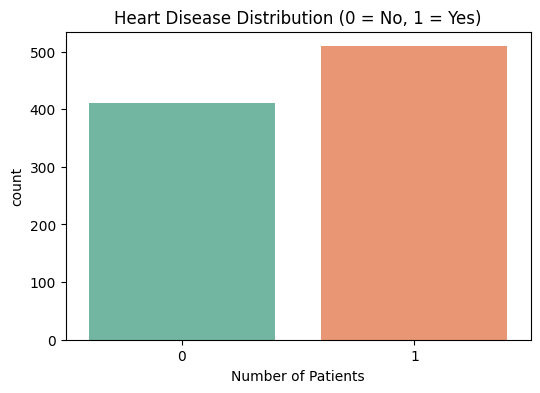

In [79]:
# Plot the counts

plt.figure(figsize=(6,4))
sns.countplot(x = "target", data = df, palette = 'Set2')
plt.title("Heart Disease Distribution (0 = No, 1 = Yes)")
plt.xlabel('Number of Patients')
plt.show()

#### Exploratory Data Analysis (EDA)

##### Numerical Features

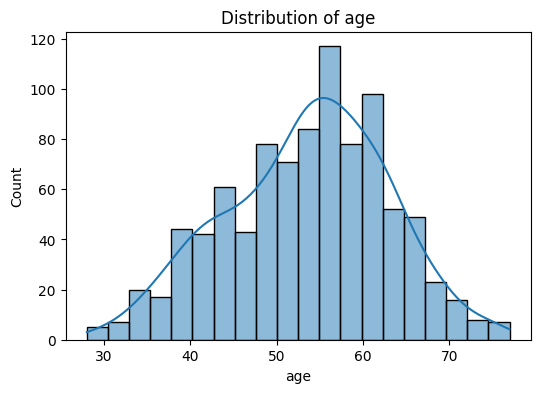

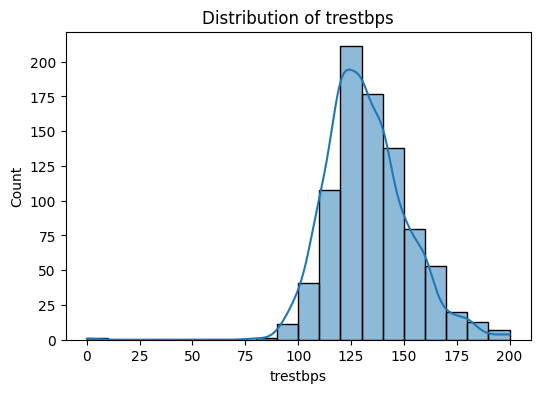

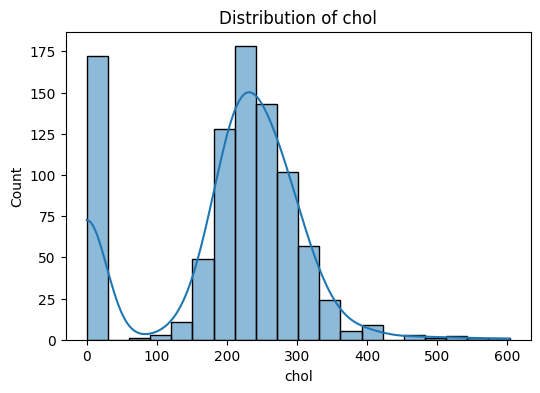

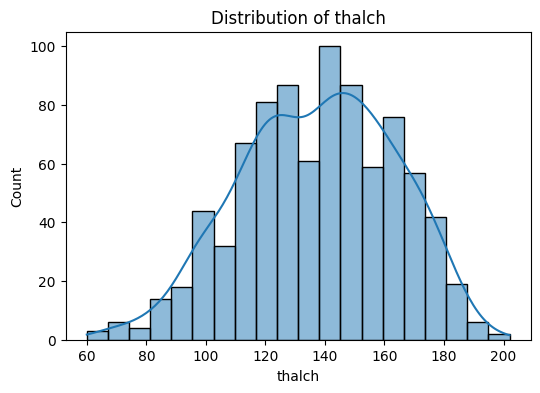

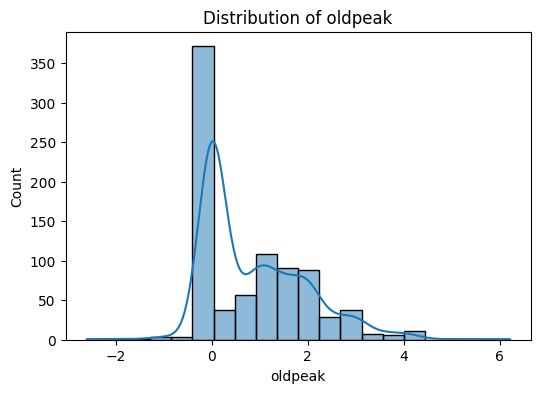

In [80]:
# Ditribution of the numeric features

numeric_features = df.select_dtypes(include="number").columns.drop("target")

for col in numeric_features:
    plt.figure(figsize=(6,4))
    sns.histplot(data = df, x = col, kde = True, bins = 20)
    plt.title(f"Distribution of {col}")
    plt.show()

In [81]:
# Boxplots of numeric features vs Attrition

for col in numeric_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x = 'Attrition', y = col, data = df)
    plt.title(f"{col} vs Attrition")
    plt.show()

ValueError: Could not interpret value `Attrition` for `x`. An entry with this name does not appear in `data`.

<Figure size 600x400 with 0 Axes>

##### Categorical Features

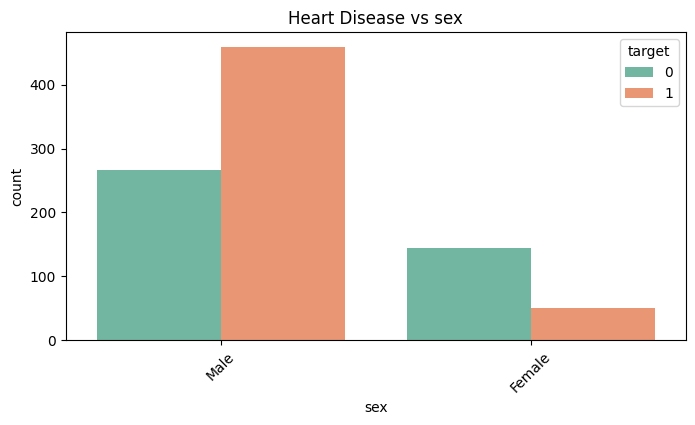

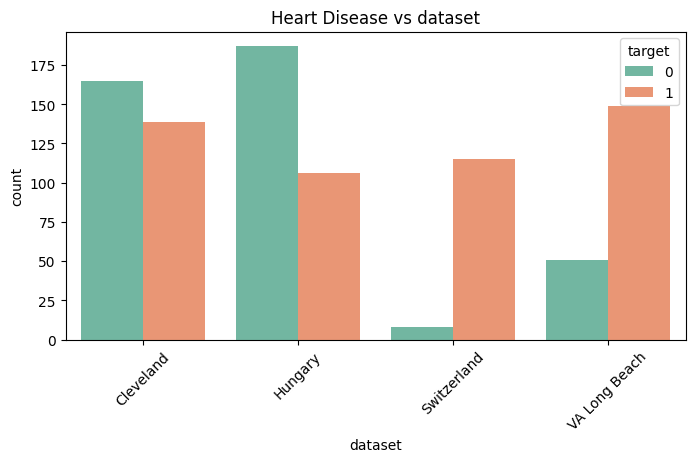

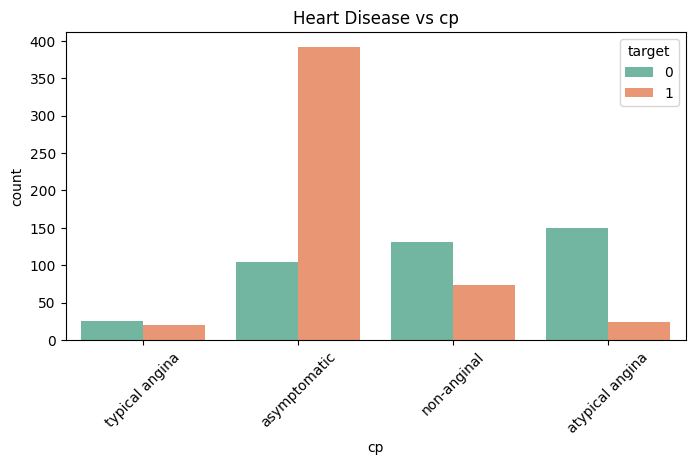

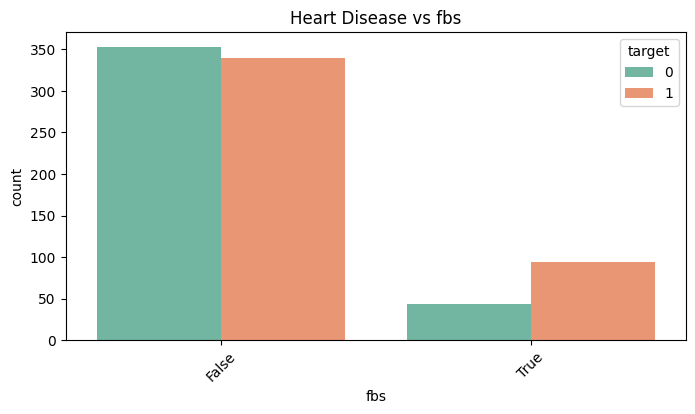

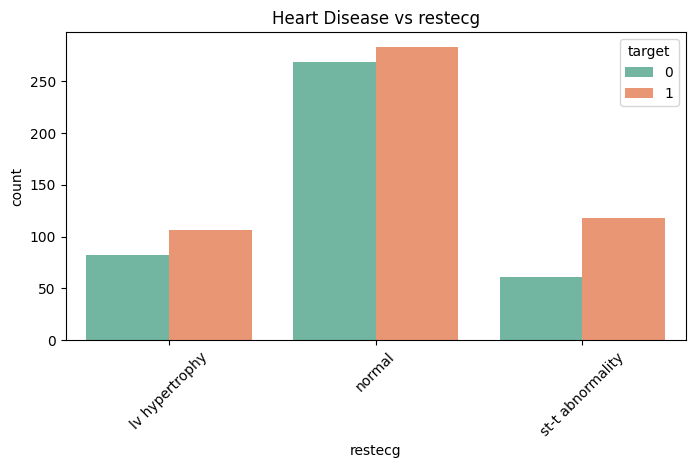

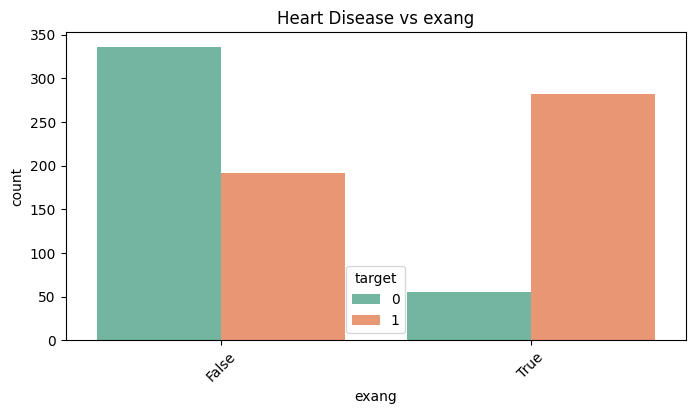

In [ ]:
categorical_features = df.select_dtypes(exclude="number").columns

for col in categorical_features:
    plt.figure(figsize=(8,4))
    sns.countplot(x = col, hue = 'target', data = df, palette = 'Set2')
    plt.title(f"Heart Disease vs {col}")
    plt.xticks(rotation=45)
    plt.show()

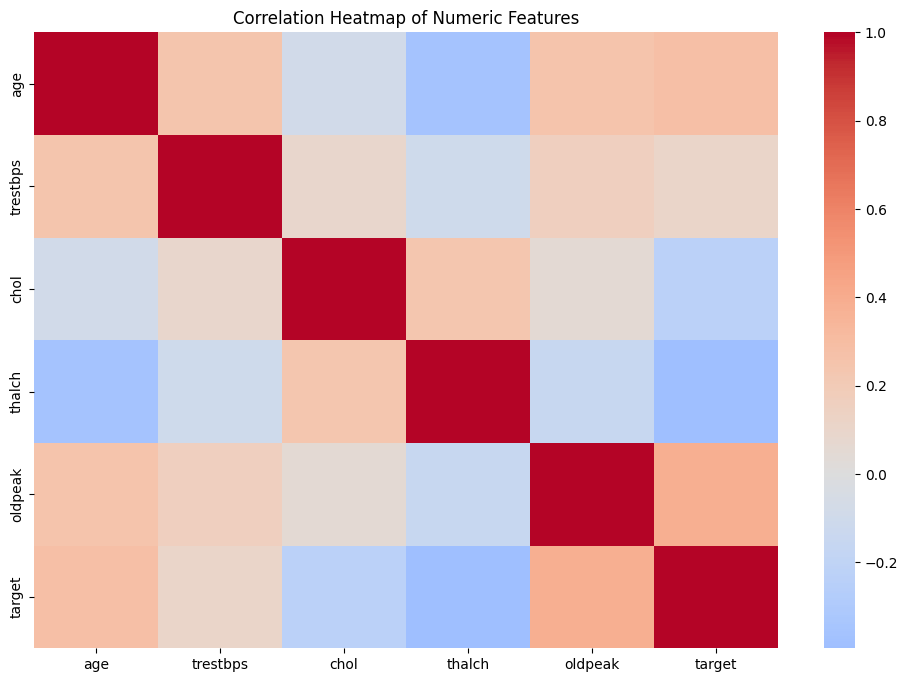

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

##### Checking for outliers

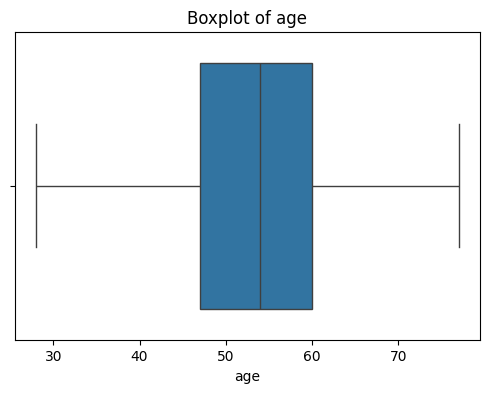

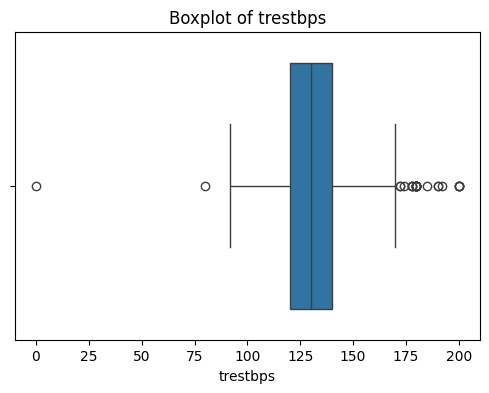

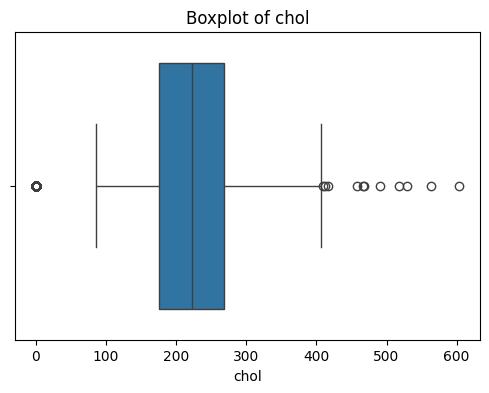

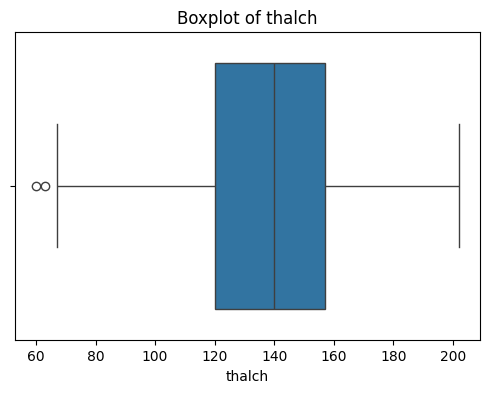

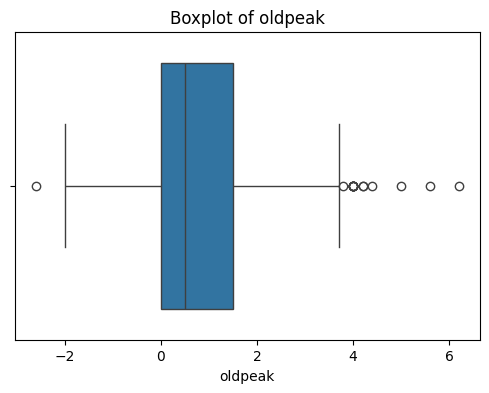

In [ ]:
# Boxplots for numeric features
for col in numeric_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

#### Data Preprocessing and Feature Engineering

In [85]:
# Identify the numeric and categorical features
numeric_features = df.select_dtypes(include=['int64','float64']).drop(columns=['target']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Drop rows with NaN values
df = df.dropna()

# Encode categorical features using One Hot Encoding
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Scale numeric features
scaler = StandardScaler()
df_encoded[numeric_features] = scaler.fit_transform(df_encoded[numeric_features])

# Separate features and target
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Numeric features: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
Categorical features: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang']


#### Model 1: Logistic Regression

Classification Report - Logistic Regression:
              precision    recall  f1-score   support

  No Disease       0.82      0.81      0.82       107
     Disease       0.83      0.83      0.83       115

    accuracy                           0.82       222
   macro avg       0.82      0.82      0.82       222
weighted avg       0.82      0.82      0.82       222



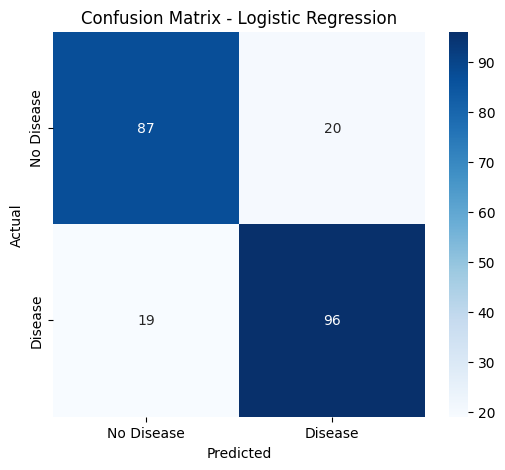

In [86]:
logistic_regression_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

logistic_regression_model.fit(X_train, y_train)

y_pred = logistic_regression_model.predict(X_test)
y_prob = logistic_regression_model.predict_proba(X_test)[:, 1]

# Classification Report
print("Classification Report - Logistic Regression:")
print(classification_report(y_test, y_pred, target_names=['No Disease','Disease']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease','Disease'], yticklabels=['No Disease','Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

#### Model 2 : Decision Tree

Classification Report - Decision Tree:
              precision    recall  f1-score   support

  No Disease       0.74      0.65      0.69       107
     Disease       0.71      0.78      0.74       115

    accuracy                           0.72       222
   macro avg       0.72      0.72      0.72       222
weighted avg       0.72      0.72      0.72       222



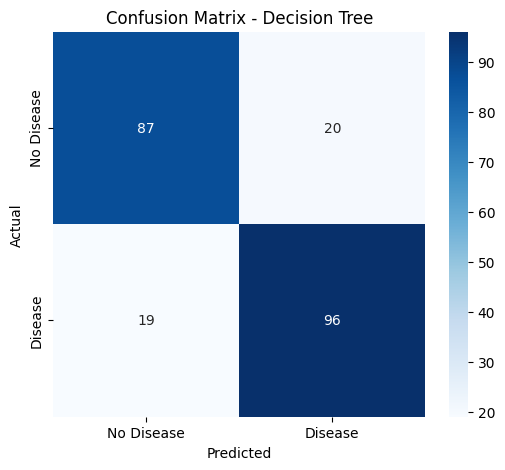

In [93]:
decision_tree_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)


decision_tree_model.fit(X_train, y_train)

y_pred_dt = decision_tree_model.predict(X_test)
y_prob_dt = decision_tree_model.predict_proba(X_test)[:, 1]

# Classification Report
print("Classification Report - Decision Tree:")
print(classification_report(y_test, y_pred_dt, target_names=['No Disease','Disease']))

# Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease','Disease'], yticklabels=['No Disease','Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.show()


#### Model 3 : RandomForest

Classification Report - Random Forest:
              precision    recall  f1-score   support

  No Disease       0.81      0.78      0.79       107
     Disease       0.80      0.83      0.81       115

    accuracy                           0.80       222
   macro avg       0.80      0.80      0.80       222
weighted avg       0.80      0.80      0.80       222



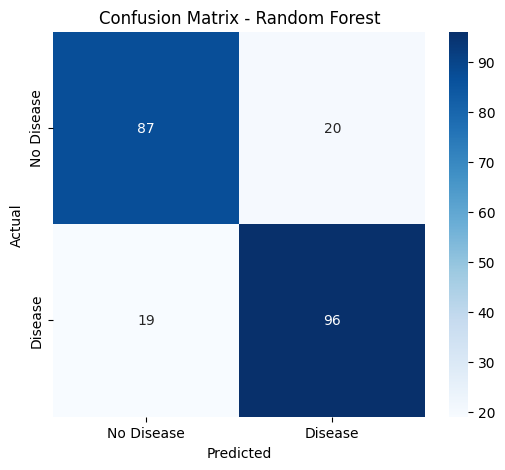

In [94]:
random_forest_model = RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42)

random_forest_model.fit(X_train, y_train)

y_pred_rf = random_forest_model.predict(X_test)
y_prob_rf = random_forest_model.predict_proba(X_test)[:, 1]

# Classification Report
print("Classification Report - Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=['No Disease','Disease']))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease','Disease'], yticklabels=['No Disease','Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()


#### Model 4 : GradientBoosting

Classification Report - Gradient Boosting :
              precision    recall  f1-score   support

  No Disease       0.82      0.79      0.80       107
     Disease       0.81      0.83      0.82       115

    accuracy                           0.81       222
   macro avg       0.81      0.81      0.81       222
weighted avg       0.81      0.81      0.81       222



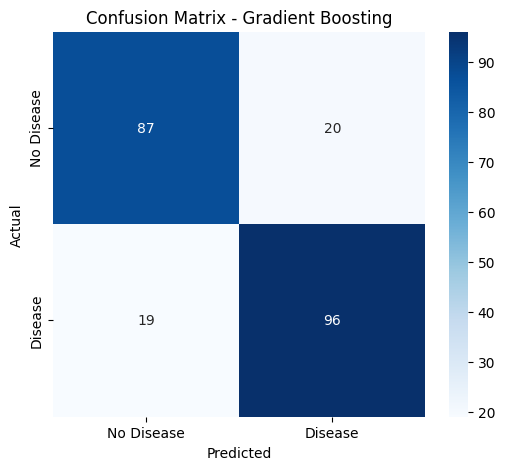

In [95]:
gradient_boosting_model = GradientBoostingClassifier(random_state=42)

gradient_boosting_model.fit(X_train, y_train)

y_pred_gb = gradient_boosting_model.predict(X_test)
y_prob_gb = gradient_boosting_model.predict_proba(X_test)[:, 1]

# Classification Report
print("Classification Report - Gradient Boosting :")
print(classification_report(y_test, y_pred_gb, target_names=['No Disease','Disease']))

# Confusion Matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease','Disease'], yticklabels=['No Disease','Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Gradient Boosting')
plt.show()

#### Model 5: XGBoost

Classification Report - XGBoost:
              precision    recall  f1-score   support

  No Disease       0.78      0.74      0.76       107
     Disease       0.77      0.81      0.79       115

    accuracy                           0.77       222
   macro avg       0.78      0.77      0.77       222
weighted avg       0.78      0.77      0.77       222



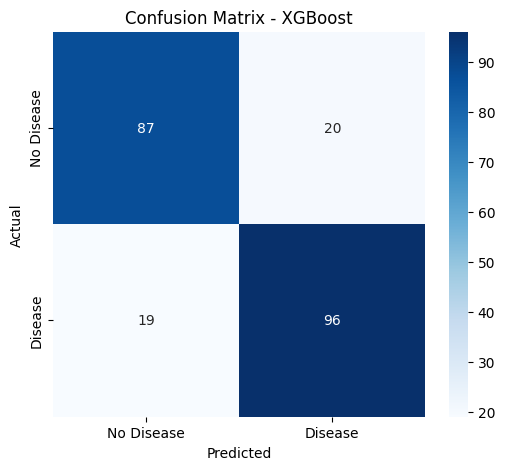

In [96]:
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]))

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Classification Report
print("Classification Report - XGBoost:")
print(classification_report(y_test, y_pred_xgb, target_names=['No Disease','Disease']))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease','Disease'], yticklabels=['No Disease','Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()


#### Hyperparameter Tuning with GridSearchCV - Logistic Regression

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 0.1, 'class_weight': None, 'solver': 'liblinear'}
Best CV F1 Score: 0.8095924683751244

Classification Report - Logistic Regression with GridSearchCV:
              precision    recall  f1-score   support

  No Disease       0.84      0.79      0.81       107
     Disease       0.81      0.86      0.84       115

    accuracy                           0.82       222
   macro avg       0.83      0.82      0.82       222
weighted avg       0.83      0.82      0.82       222



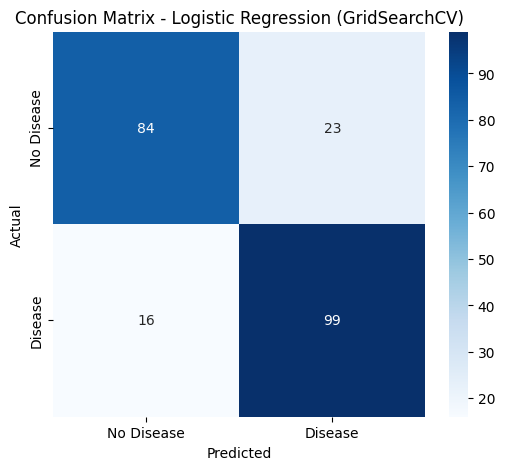

In [97]:
param_grid = {
    "C": [0.01, 0.1, 1, 10],          # regularization strength
    "solver": ["liblinear", "lbfgs"], # solvers
    "class_weight": [None, "balanced"] # handle imbalance
}

log_reg = LogisticRegression(max_iter=2000, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring="f1",   # since classes are balanced, F1 is a good metric
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit on training data
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Parameters:", grid_search.best_params_)
print("Best CV F1 Score:", grid_search.best_score_)

# Use best model
best_log_reg = grid_search.best_estimator_

# Predictions
y_pred = best_log_reg.predict(X_test)

# Evaluation
print("\nClassification Report - Logistic Regression with GridSearchCV:")
print(classification_report(y_test, y_pred, target_names=['No Disease','Disease']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease','Disease'],
            yticklabels=['No Disease','Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression (GridSearchCV)')
plt.show()
